# Leaky Integrate-and-Fire Model

A basic spiking model with exogenous spiking mechanism. Completely based in Tutorial 2.1 from Miller, 2018 (see *References*).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Model Description

The model is completely described by the leaky integration differential equation: 

$$C_m \dfrac{dV_m}{dt} = G_L(E_L - V_m) + I_{app}$$

or, equivalently:

$$C_m \dfrac{dV_m}{dt} = \dfrac{(E_L - V_m)}{R_L} + I_{app}$$


And the exogenous spiking mechanism: 

$$ V_m = V_{reset}$$ whenever $V_m > V_{th}$

Where: 

- $C_m$ is the membrane's capacitance
- $V_m$ is the membrane's potential 
- $G_L$ is the leak conductance ($R_L$ the leak resistance)
- $E_L$ is the reverse potential of the leak potential
- $I_{app}$ is the externally applied current
- $V_{reset}$ is the reset value of the membrane's potential after a spike
- $V_{th}$ is the potential threshold for a spike 

More details into the biophysical motivation for the model are found in Chapter 2 from Miller, 2018.

### Euler's method

The update rule for simulating the model via Euler's method is given by:

$$ V_m(t + \Delta t) = V_m(t) + \Delta t \dfrac{G_L(E_L - V_m(t)) + I_{app}}{C_m} $$

## Simulations

In [2]:
def update_V_m(prev_V_m, timestep, G_L, E_L, C_m, I_app, noise_std):
    """
    Performs update for membrane's potential using Euler's method
    The noise std is the standard deviation of the noise term (see below)
    """
    noise_term = np.random.randn(1) * noise_std
    return prev_V_m + (timestep*(G_L*(E_L - prev_V_m) + I_app) / C_m) + noise_term*np.sqrt(timestep)

def simulate(I_app, t_max=2000, timestep=0.1, G_L=(1/5), E_L=-70, 
             C_m=2, V_th=-50, V_reset=-65, noise_std=0):
    t = np.arange(0,t_max, timestep)
    V_m = np.zeros(len(t))
    V_m[0] = E_L
    I = np.zeros(len(t)) + I_app
    spikes = np.zeros(len(t)).astype(int)
    for i in range(1,len(t)):
        V_m[i] = update_V_m(V_m[i-1], timestep, G_L, E_L, C_m, I[i], noise_std)
        if V_m[i] > V_th:
            # There is a spike in this case
            spikes[i] = 1
            V_m[i] = V_reset

    # Get firing rate in Hz
    firing_rate = 1000 * spikes.sum() / t_max
    return {"V_m": V_m,
            "t": t,
            "I": I,
            "spike_train": spikes,
            "firing_rate": firing_rate}

def plot_results(results_dict, t_min=100, t_max=300):
    fig, ax = plt.subplots(3,1, figsize=(10,18))
    ax[0].plot(results_dict["t"], results_dict["I"])
    ax[0].set_xlim((t_min, t_max))
    ax[0].set_xlabel("t (ms)", fontsize=12)
    ax[0].set_ylabel("Current", fontsize=12)
    ax[1].plot(results_dict["t"], results_dict["V_m"])
    ax[1].set_xlim((t_min, t_max))
    ax[1].set_xlabel("t (ms)", fontsize=12)
    ax[1].set_ylabel("Membrane's potential", fontsize=12)
    spike_times = results_dict["t"][results_dict["spike_train"].astype(bool)]
    ax[2].eventplot(spike_times)
    ax[2].set_xlim((t_min, t_max))
    ax[2].set_xlabel("t (ms)", fontsize=12)
    ax[2].set_ylabel("Spikes", fontsize=12)
    plt.tight_layout()
    plt.show()    

### Minimum spiking current

Given the baseline parameters defined in the function, the minimum current that will produce a spike is given by:

$$ I_{th} =G_L(V_{th} - E_L) $$

We confirm this via simulation

In [3]:
min_current = (1/5)*(-50 + 70)
spike_results = simulate(min_current + 1)
no_spike_results = simulate(min_current - 1)

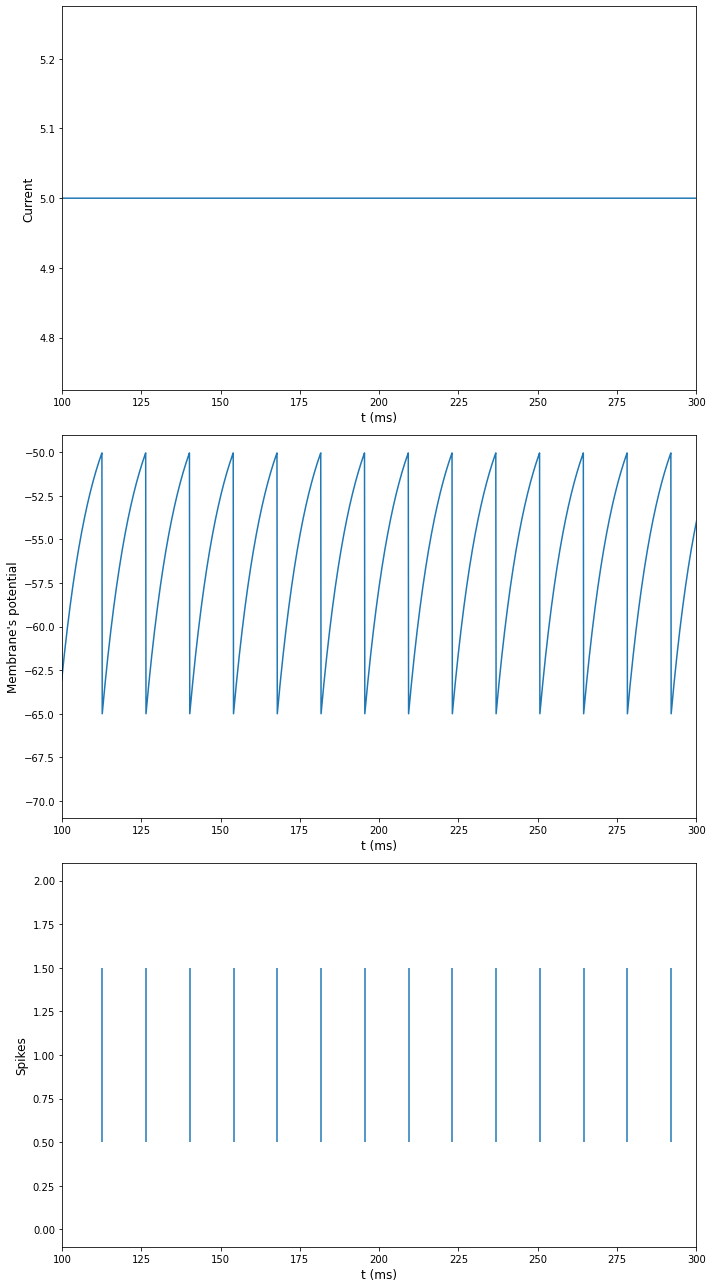

In [4]:
plot_results(spike_results)

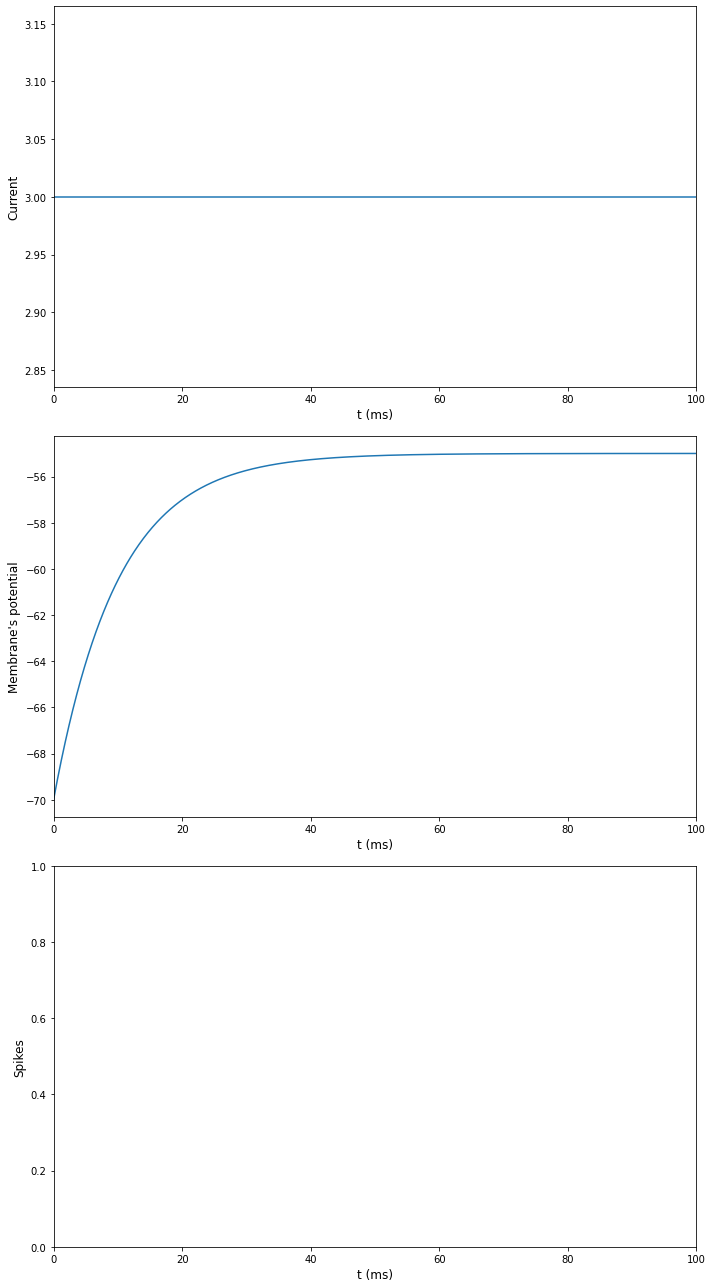

In [5]:
plot_results(no_spike_results, 0, 100)

### Firing rate and f-I Curve

The firing rate (spikes per ms.) is given by the spike count divided by the trial time (in ms). To convert to Hz (event / sec) we only multiply that rate by 1000.

The analytical solution is given by:

$$ f = \dfrac{1}{ISI}$$

Where $ISI$ is the interspike interval time and is given by:

$$ ISI = \tau_m ln(I_{app} R_m + E_L - V_{reset}) - \tau_m ln(I_{app} R_m + E_L - V_{th})$$

With $tau_m = \dfrac{C_m}{G_L}$

Note: given the parameters units defined above, this rate is in event / ms. Multiply by 1000 to convert to Hz

In [6]:
def get_f_I_curve(I_app, G_L=(1/5), E_L=-70, C_m=2, V_th=-50, V_reset=-65):
    # Create some variables to make notation the same as in equation above
    tau_m = C_m / G_L
    R_m = 1 / G_L
    # The two terms inside the log can be negative if current is small enough
    # In those cases we need to manually set the firing rate to zero instead
    term1 = I_app * R_m + E_L - V_reset
    term2 = I_app * R_m + E_L - V_th
    negative_log_mask = (term1 <= 0) | (term2 <= 0)
    return 1000 * np.where(negative_log_mask, 0,
                    1/(tau_m * np.log(term1) - tau_m * np.log(term2)))

In [7]:
# Simulated curve
I_trials = np.linspace(min_current - 1, min_current + 2, 20)
firing_rates = []
for I_app in I_trials:
    firing_rates.append(simulate(I_app)["firing_rate"])

In [8]:
# Analytical curve
fI_curve = get_f_I_curve(I_trials)

<ipython-input-6-dd6402662e14>:11: RuntimeWarning: invalid value encountered in log
  1/(tau_m * np.log(term1) - tau_m * np.log(term2)))


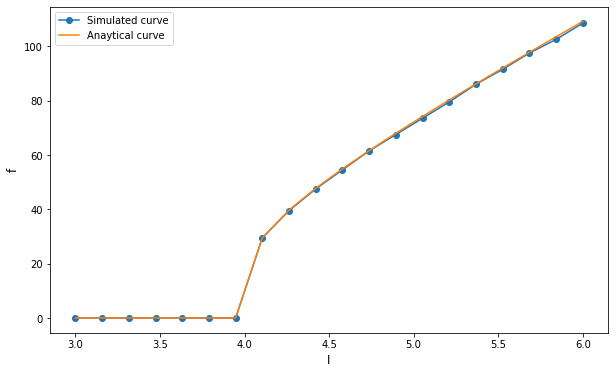

In [9]:
plt.figure(figsize=(10,6))
plt.plot(I_trials, firing_rates, marker = "o",label="Simulated curve")
plt.plot(I_trials, fI_curve, label="Anaytical curve")
plt.legend()
plt.xlabel("I", fontsize=12)
plt.ylabel("f", fontsize=12)
plt.show()

### Simulation with noise

We add a Gaussian noise term with mean 0 and variance $\sigma_I^2$ to the changes in membrane's potential.

The update rule for Euler's method is now:

$$ V_m(t + \Delta t) = V_m(t) + \Delta t \dfrac{G_L(E_L - V_m(t)) + I_{app}}{C_m}  + \epsilon_t \sqrt{\Delta t}$$

with $\epsilon_t \sim N(0, \sigma_I^2)$

In [10]:
# Simulated curve
sigma_values = [0, 0.1, 0.5, 1]
firing_rates = {}
for current_sigma in sigma_values:
    firing_rates[f"$\sigma_I = {current_sigma}$"] = []
    for I_app in I_trials:
        firing_rates[f"$\sigma_I = {current_sigma}$"].append(simulate(I_app, noise_std=current_sigma)["firing_rate"])

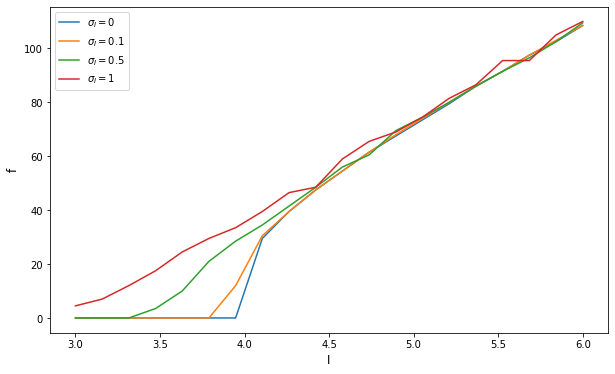

In [11]:
plt.figure(figsize=(10,6))
for sigma_value in firing_rates:
    plt.plot(I_trials, firing_rates[sigma_value],label=sigma_value)
plt.legend()
plt.xlabel("I", fontsize=12)
plt.ylabel("f", fontsize=12)
plt.show()

Increasing the voltage noise makes the firing rate to increase more linearly with respect to the applied current.

We confirm this finding by using a higer resolution of the timestep.

In [12]:
# Simulated curve
sigma_values = [0, 1]
firing_rates = {}
for current_sigma in sigma_values:
    firing_rates[f"$\sigma_I = {current_sigma}$"] = []
    for I_app in I_trials:
        firing_rates[f"$\sigma_I = {current_sigma}$"].append(simulate(I_app, timestep = 0.01,noise_std=current_sigma)["firing_rate"])

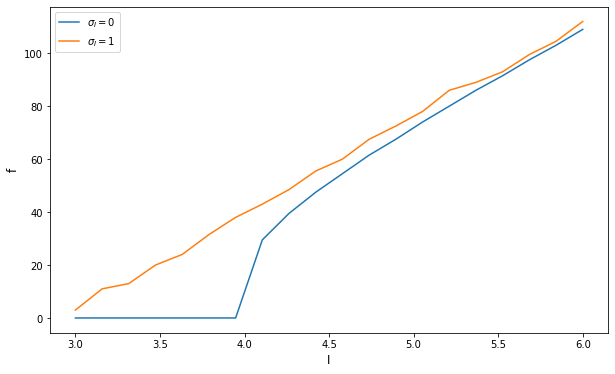

In [13]:
plt.figure(figsize=(10,6))
for sigma_value in firing_rates:
    plt.plot(I_trials, firing_rates[sigma_value],label=sigma_value)
plt.legend()
plt.xlabel("I", fontsize=12)
plt.ylabel("f", fontsize=12)
plt.show()

Intuitively this result makes sense because the added noise to the voltage differential equation enables spikes even when the current would be too low to cross the threshold in the absence of noise. Thus a noise with high variance allows the voltage to reach the spiking threshold even if the current is low. This in turn, removes the discontinuity of the firing rate at $I_{th}$

## References

Miller, Paul. An introductory course in computational neuroscience. MIT Press, 2018.